# How Many Journals Are There? Beginning to Count the Discounted
Jon Ball, Saurabh Khanna, Juan Alperin, and John Willinsky

#### Abstract
This paper describes the scope of scholarly journal activity largely concentrated in the Global South that relies on the open source publishing platform Open Journal Systems (OJS). It takes advantage of indexing data collected from most of the OJS-deploying journals to provide a detailed picture of 25,671 open access journals that published at least five articles a year in 2020, of which 20,871 (81.7 percent) are published in the Global South. These journals form part of a band of scholarly publishing that is often under-counted and dis-counted. 

Areas considered include the global distribution of journals among 136 countries, the disciplinary distribution, the linguistic richness represented by publications in 54 languages, the citation leaders, indexing coverage, including among so-called predatory lists. 


### Notebook objectives:
1. [Clean the Open Journal Systems beacon dataset and save the cleaned copy.](#beacon)
2. [Visualize growth in the number of journals actively using OJS.](#activeojs)
3. [Concatenate journal titles and abstracts contained in the OJS data dump, to use as inputs to a disciplinary classifier.](#datadump) 

## Data Preprocessing <a name="beacon"></a>
Import packages and read the beacon dataset into pandas:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from collections import Counter
import gcld3
import ijson
import json
import time
import os
import re

In [2]:
beacon = pd.read_csv('data/beacon.csv')

Slice the beacon DataFrame so that it includes only **active journals (publishing 5 or more articles in 2020)**:

In [3]:
beaconActive = beacon[beacon['record_count_2020'] >= 5].reset_index(drop=True)

Clean the 'oai_url' variable:

In [4]:
#Several 'oai_url' vars contain duplicates and trailing punctuation
beaconActive['oai_url'] = beaconActive['oai_url'].str.split(r'\s|\?').str.get(0).str.replace('[\./]+$', '', regex=True)

Split the 'issn' variable, because it contains some duplicates:

In [5]:
#Several issn vars contain two issns separated by '\n'
beaconActive['issn_1'] = beaconActive['issn'].str.split(r'\n').str.get(0)
beaconActive['issn_2'] = beaconActive['issn'].str.split(r'\n').str.get(1)

Create a new 'journal_url' column for accessing journal web pages:

In [6]:
pattern = re.compile("index/oai$|oai$")

def create_url(row):
    return pattern.sub("", row["oai_url"]) + row["set_spec"]

beaconActive['journal_url'] = beaconActive.apply(create_url, axis=1)

Check for missing values and duplicates:

In [7]:
beaconActive.isnull().sum()

oai_url                      0
application                  0
version                     34
admin_email                658
earliest_datestamp          99
repository_name           4143
set_spec                     0
context_name                 0
stats_id                     0
total_record_count           0
issn                      2910
country_marc              2947
country_issn              3022
country_tld               5367
country_ip                 282
country_consolidated        94
last_completed_update       22
first_beacon                 0
last_beacon                  0
last_oai_response           99
unresponsive_endpoint        0
unresponsive_context         0
record_count_2010            0
record_count_2011            0
record_count_2012            0
record_count_2013            0
record_count_2014            0
record_count_2015            0
record_count_2016            0
record_count_2017            0
record_count_2018            0
record_count_2019            0
record_c

In [8]:
beaconActive.duplicated().any()

False

In [9]:
beaconActive.to_csv('data/beacon_active.csv')

## Journals using OJS <a name=activeojs></a>
### Growing number of active journals, articles published using OJS (2010-2020)

In [10]:
#Drop duplicate journal titles from the beacon DataFrame
beacon.drop_duplicates(subset='context_name', inplace=True)
#Pull 'record_count' column names and store in a list 
record_cols = beacon.columns[beacon.columns.str.contains('record_count_2')].tolist()
#Create a numpy array where cells represent record counts by journal, year
#Convert cells where record_count >=  5 -> 1, else 0
beaconGrowth = np.where(beacon[record_cols[:-1]] >= 5, 1, 0) #index record_cols to exlude year 2021 [-1]

Plot the total number of active journals using OJS by year (2010-2020):

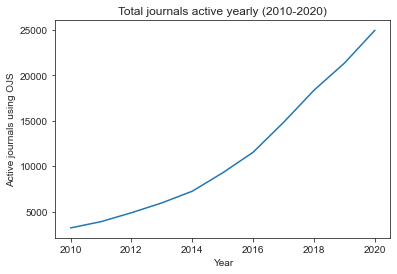

In [11]:
%matplotlib inline
#Set style for sns
sns.set_style('white')
sns.set_style('ticks')

active_journal_growth = sns.lineplot(x = range(2010,2021), y = beaconGrowth.sum(axis=0))
active_journal_growth.set(xlabel = 'Year',
                          ylabel = 'Active journals using OJS',
                          title = 'Total journals active yearly (2010-2020)')
matplotlib.pyplot.show()

Plot the number of new articles published each year (2010-2020):

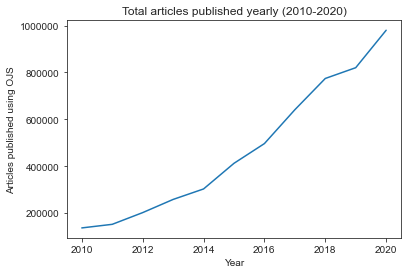

In [12]:
%matplotlib inline

article_growth = sns.lineplot(x = range(2010,2021), y = beacon[record_cols[:-1]].sum().to_list())
article_growth.set(xlabel = 'Year',
                   ylabel = 'Articles published using OJS',
                   title = 'Total articles published yearly (2010-2020)')
article_growth.ticklabel_format(style='plain')
matplotlib.pyplot.show()

## Preprocessing article titles and abstracts for disciplinary classification <a name=datadump></a>

Finally, create a function that concatenates article titles and abstracts contained in the data dump. These string "payloads" are mapped to journal ISSNs, serving as inputs for journal-level disciplinary classification. The function:
<br>
1. Opens and streams a datadump.json file of journal issns mapped to titles and short descriptions / abstracts;
- {issn: {title: list(str), description: list(str)}}
<br><br>
2. Concatenates titles and abstracts into a single `payload` for each journal issn, for use as a classifier input;
    - The `payload` consists of **200-300 words for each journal** (a small sample to preserve computer memory later, during translation)
    - These words are pulled from the `title` and `abstract` metadata fields of each of the **5 most recent articles published in each journal**
    - Titles and abstracts are truncated at 30 words, then concatenated to form the classifier input
<br><br>
3. Saves files containing payloads separately, **by language**, as json-encoded dictionaries {issn: payload}: 

In [13]:
def parse_split_save(path_to_json, data_dir, classifier, language_code):
    
    issn2payload = defaultdict(str) #function returns a dictionary mapping ISSN -> payload of titles and abstracts
    title_count = defaultdict(int) #count titles, 5 per journal
    abstract_count = defaultdict(int) #count abstracts, 5 per journal
    
    issn = ''
    title_prefix = ''
    description_prefix = ''
    outstr = ''
    journal_count = 0
    
    with open(path_to_json, 'r') as f: #open json file, streamed as dict(dict(list(str)))
        for prefix, event, value in ijson.parse(f): #parse each json event iteratively
            
            if event == 'map_key': #if the event is a new dictionary
                if re.search('\d{4}-\d{4}', value): #and the value of the key is an issn
                    
                    issn = value #store the issn to use as a prefix
                    title_prefix = issn + '.' + 'title' + '.' + 'item' #store a 'title' prefix
                    description_prefix = issn + '.' + 'description' + '.' + 'item' #store a 'description' prefix
                    journal_count += 1 #add to the journal count
                
            elif (prefix, event) == (title_prefix, 'string'): #if the json event is a 'title' string
                if title_count[issn] < 5 and len(value) > 10: #take 5 titles per journal 
                    #if 'title' string is not arbitrary
                    pred_ = classifier.FindLanguage(text=value)
                    if pred_.is_reliable and pred_.language == language_code: #if the title is in the specified language
                        outstr = ' '.join(tok.strip('\n') for tok in value.split()[:30]) #clip at 30 tokens for memory needs
                        issn2payload[issn] += outstr #concatenate the new description with payload
                        issn2payload[issn] += ' '
                        title_count[issn] += 1
                    del pred_
                        
            elif (prefix, event) == (description_prefix, 'string'): #if the json event is a 'description' string
                if abstract_count[issn] < 5 and len(value) > 10: #take 10 articles+titles per journal
                    #if 'description' string is not arbitrary (<10 characters)
                    pred_ = classifier.FindLanguage(text=value)
                    if pred_.is_reliable and pred_.language == language_code: #if the abstract is in specified language
                        outstr = ' '.join(tok.strip('\n') for tok in value.split()[:30]) #clip at 30 tokens for memory needs
                        issn2payload[issn] += outstr #concatenate the new abstract with payload
                        issn2payload[issn] += ' '
                        abstract_count[issn] += 1
                    del pred_
    
            else:
                continue
                
    print('Total journal count: {}'.format(journal_count) + '\n')
    
    filename = 'issn2' + language_code + '.json'
    print('Saving at {}...'.format(filename))

    with open(os.path.join(data_dir, filename), 'w') as f:
        json.dump(issn2payload, f)
        print("{} '{}' payloads saved as json.".format(len(issn2payload), language_code))
    
    del issn2payload

Call the function and save journal samples in several prominent languages to complete preprocessing:

In [14]:
path_to_json = os.path.join('data', 'datadump.json')
data_dir = os.path.join('data')
classifier = gcld3.NNetLanguageIdentifier(min_num_bytes=0, max_num_bytes=10000)

English:

In [15]:
%time parse_split_save(path_to_json, data_dir, classifier, language_code='en')

Total journal count: 20543

Saving at issn2en.json...
18140 'en' payloads saved as json.
CPU times: user 13min 35s, sys: 6min 7s, total: 19min 42s
Wall time: 19min 51s


Bahasa Indonesia:

In [16]:
%time parse_split_save(path_to_json, data_dir, classifier, language_code='id')

Total journal count: 20543

Saving at issn2id.json...
9034 'id' payloads saved as json.
CPU times: user 29min 25s, sys: 5min 53s, total: 35min 19s
Wall time: 35min 25s


Spanish:

In [17]:
%time parse_split_save(path_to_json, data_dir, classifier, language_code='es')

Total journal count: 20543

Saving at issn2es.json...
5124 'es' payloads saved as json.
CPU times: user 50min 58s, sys: 6min 14s, total: 57min 13s
Wall time: 57min 15s


Portuguese:

In [18]:
%time parse_split_save(path_to_json, data_dir, classifier, language_code='pt')

Total journal count: 20543

Saving at issn2pt.json...
4194 'pt' payloads saved as json.
CPU times: user 55min 26s, sys: 6min 21s, total: 1h 1min 48s
Wall time: 1h 1min 49s


Afrikaans:

In [19]:
%time parse_split_save(path_to_json, data_dir, classifier, language_code='af')

Total journal count: 20543

Saving at issn2af.json...
1196 'af' payloads saved as json.
CPU times: user 1h 12min 9s, sys: 6min 45s, total: 1h 18min 55s
Wall time: 1h 18min 57s


Japanese:

In [20]:
%time parse_split_save(path_to_json, data_dir, classifier, language_code='ja')

Total journal count: 20543

Saving at issn2ja.json...
290 'ja' payloads saved as json.
CPU times: user 1h 14min 54s, sys: 7min 1s, total: 1h 21min 56s
Wall time: 1h 21min 57s


Russian:

In [21]:
%time parse_split_save(path_to_json, data_dir, classifier, language_code='ru')

Total journal count: 20543

Saving at issn2ru.json...
743 'ru' payloads saved as json.
CPU times: user 1h 12min 27s, sys: 7min 2s, total: 1h 19min 30s
Wall time: 1h 19min 31s


French:

In [22]:
%time parse_split_save(path_to_json, data_dir, classifier, language_code='fr')

Total journal count: 20543

Saving at issn2fr.json...
2326 'fr' payloads saved as json.
CPU times: user 1h 7min 25s, sys: 6min 41s, total: 1h 14min 7s
Wall time: 1h 14min 8s


Malay:

In [23]:
%time parse_split_save(path_to_json, data_dir, classifier, language_code='ms')

Total journal count: 20543

Saving at issn2ms.json...
7958 'ms' payloads saved as json.
CPU times: user 47min 34s, sys: 6min 13s, total: 53min 48s
Wall time: 53min 48s


Ukrainian:

In [24]:
%time parse_split_save(path_to_json, data_dir, classifier, language_code='uk')

Total journal count: 20543

Saving at issn2uk.json...
516 'uk' payloads saved as json.
CPU times: user 1h 13min 9s, sys: 6min 35s, total: 1h 19min 44s
Wall time: 1h 19min 46s


Italian:

In [25]:
%time parse_split_save(path_to_json, data_dir, classifier, language_code='it')

Total journal count: 20543

Saving at issn2it.json...
2562 'it' payloads saved as json.
CPU times: user 1h 8min 48s, sys: 6min 26s, total: 1h 15min 14s
Wall time: 1h 15min 15s


Polish:

In [26]:
%time parse_split_save(path_to_json, data_dir, classifier, language_code='pl')

Total journal count: 20543

Saving at issn2pl.json...
575 'pl' payloads saved as json.
CPU times: user 1h 13min 35s, sys: 6min 30s, total: 1h 20min 5s
Wall time: 1h 20min 6s


German:

In [27]:
%time parse_split_save(path_to_json, data_dir, classifier, language_code='de')

Total journal count: 20543

Saving at issn2de.json...
1389 'de' payloads saved as json.
CPU times: user 1h 11min 18s, sys: 6min 27s, total: 1h 17min 46s
Wall time: 1h 17min 47s


Arabic:

In [28]:
%time parse_split_save(path_to_json, data_dir, classifier, language_code='ar')

Total journal count: 20543

Saving at issn2ar.json...
493 'ar' payloads saved as json.
CPU times: user 1h 11min 53s, sys: 6min 51s, total: 1h 18min 45s
Wall time: 1h 18min 49s
